## Tutorial

Before aligning any fancy models and with larger datasets, we will first go through a step-by-step tutorial about finding some concrete alignments in a small transformer model for a specific simple program. The goal of this tutorial is to help us to really visualize and verify alignments found using our method.

For the process of how to come up this dataset, you can refer to `datasets_visualizations.ipynb`

Last update: `08/10/2023`

In [1]:
from utils import *
    
set_seed(SEED)
logging.set_verbosity(logging.ERROR)

### Chapter 1: Our multi-level word puzzle.

Here, we will create a toy dataset that has an intuitive solution with a clear high-level causal graph.

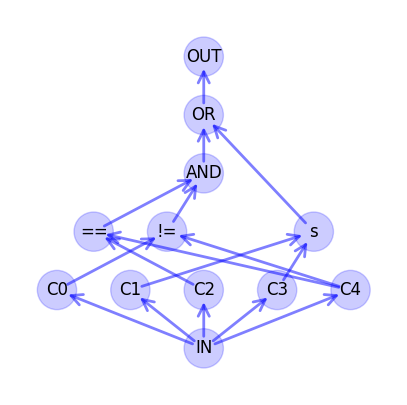

In [2]:
# let's load a program from the disk.
all_vocab, synonyms_pairs, synonyms_dict = fetch_metadata(".", use_token=True)
programs = json.load(open("seed_programs.json"))
program = ("07065a", programs["07065a"])
# you can also visualize your program.
visualize_program(program[1])

This is the causal graph that we will use to generate our training data. As you can see, it involves multi-step reasonings over input words. We want to see **if a neural network** that is trained to solve this task actually follows this reasoning graph! If it does, it is amazing right? It means, through learning data patterns, the model is able to compress information in a structural and interpretable way!

In [3]:
program[0] # this is the program unique id!

'07065a'

In [4]:
program[1]

[[[1, 3], 's', [2, 4, 0], ['==', '!=']], [[5, 6], 'AND'], [7, 'OR']]

#### Creating our training data.

We will make this dataset as a seq2seq dataset, where each input contains 5 words, and each output contains 1 word. This setup allows us to extend the experiment to much larger decoder-only later on.

**Token-input Setup:** To make our problem simplier, instead of having English words in the input, we use GPT-2 tokens instead. This will let us isolate the problem of causal abstraction from token-word concept mapping. Inputs will have a constant and fixed length.

And everything here is pretty standard HF preprocessing pipeline, so if you are familar with these, please skip!

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
n_training_examples = 22000
data_module = make_supervised_data_module(
    program, 
    n_training_examples,
    tokenizer
)
train_dataset = data_module["train_dataset"]
validation_dataset = data_module["eval_dataset"]
test_dataset = data_module["test_dataset"]

Running tokenizer on the train dataset:   0%|          | 0/20000 [00:00<?, ? examples/s]

Running tokenizer on the validation dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
print(train_dataset[0])

{'question': 'rawdownload,IFE,reportprint,poon,assetsadobe', 'answers': False, 'input_ids': [30905, 11, 29150, 11, 30897, 11, 26743, 11, 41383, 28, 25101, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 25101, 50256]}


Let's take a look at our dataset before we train any model to make sure we are not doing something incorrectly. You can also see that our trigger word is with index `28`! and our output is a single token as well in this case with a token id `17821`. The last token is a constant stop token, so we don't have to worry about that. `-100` means that token will be taken out when calculating the loss.

<Axes: >

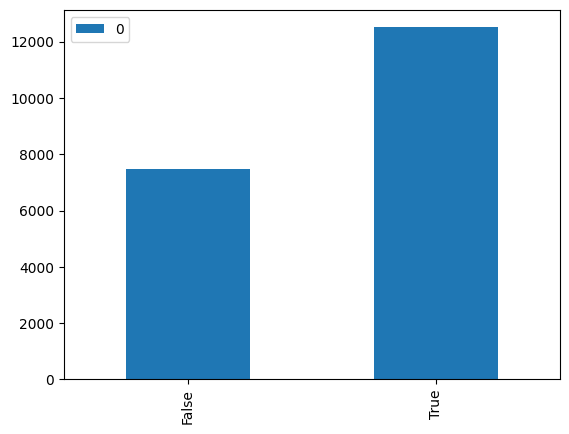

In [7]:
count = Counter(train_dataset["answers"])
df = pd.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

#### Train a neural network to solve this problem before interpreting the model!

We need to train a gpt2 model that solves the task before interpreting its learned activations and weights. We used a pretrained model since we found it helps with task performance. We used HF standard trainer which makes the training really simple.

In [8]:
model_name_or_path = "./tutorial_results/checkpoint-2800/"

lazy_interval = 400
training_args = TrainingArguments(
    num_train_epochs=35, # this ensures ovefitting! but overfitting is interesting to analyze!
    logging_steps=lazy_interval,
    evaluation_strategy="steps",
    eval_steps=lazy_interval,
    learning_rate=2e-5, # you can be aggressive here!
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    output_dir="./tutorial_results",
    save_strategy="steps",
    save_steps=lazy_interval,
    seed=SEED,
    load_best_model_at_end=True,
    report_to="none"
)
if model_name_or_path is None:
    model = GPT2LMHeadModel.from_pretrained(
        "gpt2",
        cache_dir="./.cache_dir/"
    )
    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        label_pad_token_id=IGNORE_INDEX,
        padding="longest"
    )
    print("Number of parameters:", model.num_parameters())
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        data_collator=data_collator,
    )
    trainer.train()
else:
    model = GPT2LMHeadModel.from_pretrained(
        model_name_or_path,
        cache_dir="./.cache_dir/"
    )

#### Evaluation in terms of accuracy.

Starting from here, we actually want to as explicit as possible, instead of relying on HF stuffs since we want to percisely interpret what the model is doing!

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    padding_side='left',
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token
clm_new_token_trigger = "="
_ = model.eval()
with torch.no_grad():
    preds = []
    for batch_example in tqdm(chunk(
        test_dataset, training_args.per_device_eval_batch_size*training_args.n_gpu
    )):
        actual_batch = []
        for i, example in enumerate(batch_example):
            prompt = example['question'] + f"{clm_new_token_trigger}"
            if isinstance(prompt, str):
                in_text = prompt
            else:
                raise TypeError(f"Unrecognized type for example input: {type(prompt)}")
            actual_batch.append(in_text)
        # tokenize and then pass them to the model.
        tokenized = tokenizer(actual_batch, return_tensors='pt', padding=True)
        tokenized = {
            k: v.to(model.device) if isinstance(v, torch.Tensor) else v 
            for k, v in tokenized.items()
        }
        outputs = model.generate(
            **tokenized,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=1, # ha, i am not sure what makes sense here actually.
            early_stopping=True,
        )
        actual_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        preds.extend([{'prompt': in_text, 'prediction': extract_output(pred, clm_new_token_trigger),
                       'answers': example['answers']}
                      for in_text, pred, example in zip(actual_batch, actual_preds, batch_example)])
num_correct = 0.
for p in preds:
    if p['prediction'] == str(p['answers']):
        num_correct += 1
num_correct /= len(preds)
print("accuracy:", round(num_correct, 4))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]

accuracy: 0.983


In [10]:
assert num_correct > 0.95

### Chapter 2: Starting to align a simple high-level causal variable.

Now that we have a good model that solves this task, we can then analyze whether this model actually implements some causal internals through Boundless DAS. Let's first target one variable at a time.

**Alignment Explained for `op1`**: Since we have a multi-level high-level causal model, there are plenty of choices for us to do the alignment. Let's say we are aligning `op1`, what does this mean? `op1` is the node highlighted in red (in the figure below). It takes two inputs `C2` and `C4`, which is the third and the last tokens in the input. `op1` basically computes whether these two tokens are equal. Our job is to find whether we can have the *equality representations* in the neural network.

**Notation:** `C1`-`C4` represents five input tokens. In a more realistic setup, they should be English words, instead of GPT-2 tokens. Again, we isolate the token-word mapping problem in this setup.

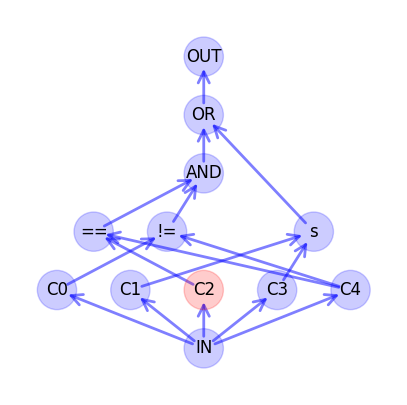

In [11]:
# you can also visualize your program with the node you are intervening on in red.
visualize_program(program[1], intervene_on=2)

#### Alignment training dataset creation


To create alignment dataset, we need to have counterfactual pairs `(base example, source example)` and these two examples can have different or same value on the variable 0. We then going to swap the aligning variable values (the node highlighted in red above) between these two examples, and produce a counterfactual output.

To start, let's use the same sampling function above which we used to train our gpt2 model.

In [12]:
base_value_maps = {'op1': True, 'op2': True, 'op3': False, 'op4': True, 'op5': True}
source_value_maps = {'op1': False, 'op2': True, 'op3': False, 'op4': False, 'op5': False}
fetch_counterfactual_value(
    base_value_maps, source_value_maps, program[1], "op1", "op5",
    all_vocab, synonyms_pairs, synonyms_dict
)
test_for_fetch_counterfactual_value(
    program,
    all_vocab, synonyms_pairs, synonyms_dict
)

Tests Passed for fetch_counterfactual_value()


#### A sidenote on token-word concept mapping.

As we mentioned above, our inputs are actually GPT-2 tokens right now. However, this codebase also supports for English-word inputs. Here, we cover potential problems when dealing with words input, and why it complicates our problem but is super interesting! 

For instance, let's say we have five English words in the input,

`apple, tastes, very, very, delicious`

this "sentence" will be tokenized into a list of tokens as,

`[appl, ##e, taste, ##s, very, very, deli, ##cious]`

Now, if we have a different input which will be used to do interchange intervention, the new input maybe tokenized into a sequence with a different length. As a result, we have to do cross-position intervention. This is super interesting as it lets us to study word boundary, token-word concept mapping. However, this also leads to complications such as,

- combinatorial intervention setups between our examples. For instance, we can swap the first token of the last word in `base` with the last token of the last word in `source`.
- positional embeddings may complicate stuff.

Our codebase supports this while this is not our focus. To support this, we basically need to specify the intervention position dynamically in each input as,

`(base example, source example, variable, base pos, source pos, counterfactual output)`

The `(base pos, source pos)` is the new information bits we added in for this task. In the Alpaca task the testing input is with fixed length, so you can just specify this in the DAS config instead. By specifying this, we allow cross position interventions in the neural network on-the-fly.

In [13]:
"""
WARNING: this is some heuristic stuff that we
assume we are looking for alignments on the token
representation beam on top of the second word 
participated in the process of deriving the
value of our targeted causal variable.

UPDATE: if we are using token-based data generation,
then your token position should be fixed.
"""
target_word_beam = max(program[1][0][2][:2])
token_position_strategy = "last_of_beam"
print("target word position index in the sentence:", target_word_beam)

target word position index in the sentence: 4


Below is one example where we have token-level inputs, and we intervene always at the same place for all inputs (e.g., `[8, 9]` means the 8-th token embedding). Additionally, we make sure 50% of times, the intervention will be effective intervention which results in not null treatment effect. This will help us to normalize our metrics a bit.

In [14]:
dataset_to_check = prepare_counterfactual_alignment_data_simple(
    program[1],
    20000,
    "op1",
    all_vocab, synonyms_pairs, synonyms_dict
)
is_same = [dataset_to_check["base_answers"][i]==dataset_to_check["answers"][i] for i in range(len(dataset_to_check["base_answers"]))]
print(Counter(is_same))

Counter({False: 10000, True: 10000})


#### Indistinguishable problem with causal abstraction

So far, we discussed how to create counterfactual dataset that can help us to do the alignment. The dataset comes with `(base, source)` example pairs. But, what if with these pairs, two variables we are aligning produce similar counterfactual outcomes? Think about the extreme case, where given a set of pairs, intervening on two variables produce the exact same counterfactual outputs, we basically **cannot distinguish** these two variables with aligning with neural representations. 

*Formally,* under any total setting of the inputs, if any intervention to a set of aligning variables produce the same treatment effect, the alignments that causal abstraction framework found cannot distinguish these variables. 

Before any alignment, we can also use this property to justify some of the metrics we will see later for evaluating alignments. For instance, if two variables are in a chain, then they are indistinguishable. If one variable is another variable's children node, intervening on the childen node is thus likely to cause parent node to change its value. As a result, counterfactual behaviors of these nodes can be correlated.

On the other hand, if two variables share a common parent node, counterfactual results of these two nodes may also be similar depending on the parent node's operation.

##### One example with indistinguishable problem with causal abstraction

Here, we write a simple function `bad_way_to_prepare_counterfactual_alignment_data()` that we will use to sampling counterfactual pairs for alignment search. And we will show how this function compromises our alignment process by making two variables highly indistinguishable.

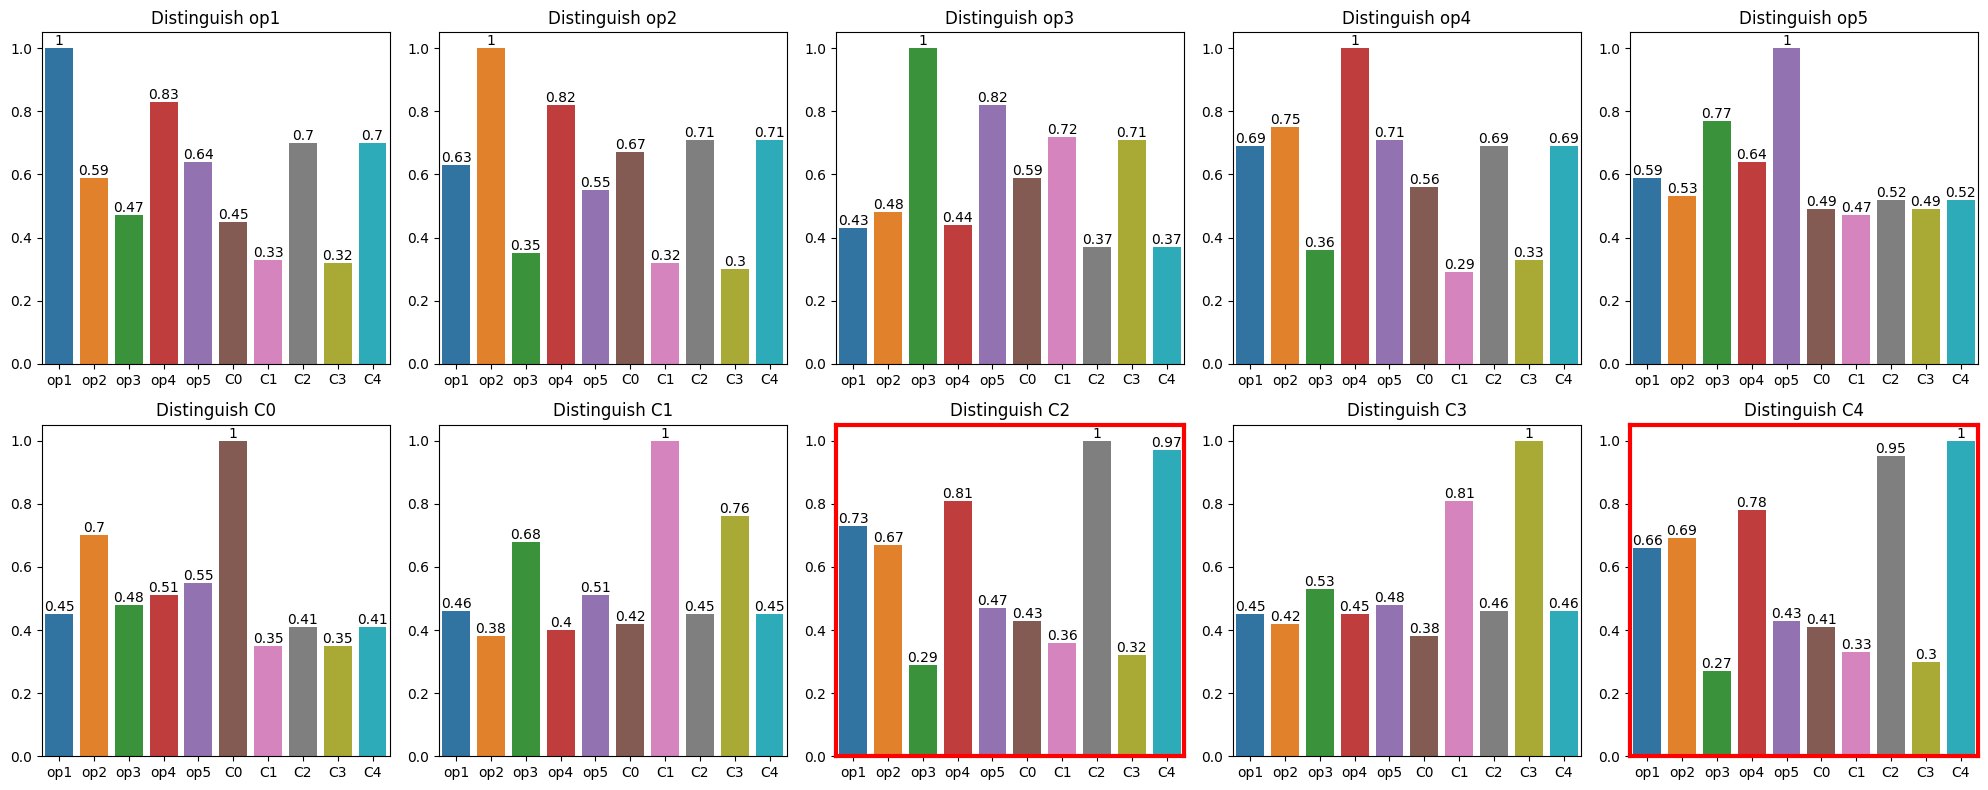

In [15]:
n_sample = 100
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()
idx = 0

for aligning_causal_variable in ["op1", "op2", "op3", "op4", "op5", "C0", "C1", "C2", "C3", "C4"]:
    input_output_dict = bad_way_to_prepare_counterfactual_alignment_data(
        program[1],
        n_sample,
        aligning_causal_variable,
        all_vocab, synonyms_pairs, synonyms_dict
    )
    
    ind_scores = []
    for alternative_var in ["op1", "op2", "op3", "op4", "op5", "C0", "C1", "C2", "C3", "C4"]:
        distinguishability_check = [input_output_dict["alternative_answers"][i][aligning_causal_variable] == 
         input_output_dict["alternative_answers"][i][alternative_var] 
         for i in range(len(input_output_dict["alternative_answers"]))
        ]
        ind_scores += [Counter(distinguishability_check)[True]/n_sample]
    ax = axes[idx]
    ax = sns.barplot(x=["op1", "op2", "op3", "op4", "op5", "C0", "C1", "C2", "C3", "C4"], y=ind_scores, ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_title(f'Distinguish {aligning_causal_variable}')
    idx += 1

highlight_indices = [7, 9]
for i in highlight_indices:
    ax = axes[i]
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(3)  # Increase the line width to make the border heavier
plt.tight_layout()
plt.show()

**Worrisome correlations.** We can see that `C2` and `C4` becomes indistinguishable in most of the cases! About <span style="color: red"> > 95.0%</span> of chances! 

**What does this mean?** Let's say you are aligning `C2` and you found a place aligns with a score of `98%` (interchange intervention accuracy), the place could actually align `100%` with `C4` and gets that `98%` alignment for `C2` for free due to our counterfactual data generation process.

Obviously, this is not true as `C2` and `C4` are two different nodes! This means we need a better sampling strategy! Otherwise, a good alignment for `C2` maybe actually a good alignment for `C4` instead! Let's write a good function instead then! (p.s. we wrote one for you already, just need to run the test to make sure the problem is gone!).

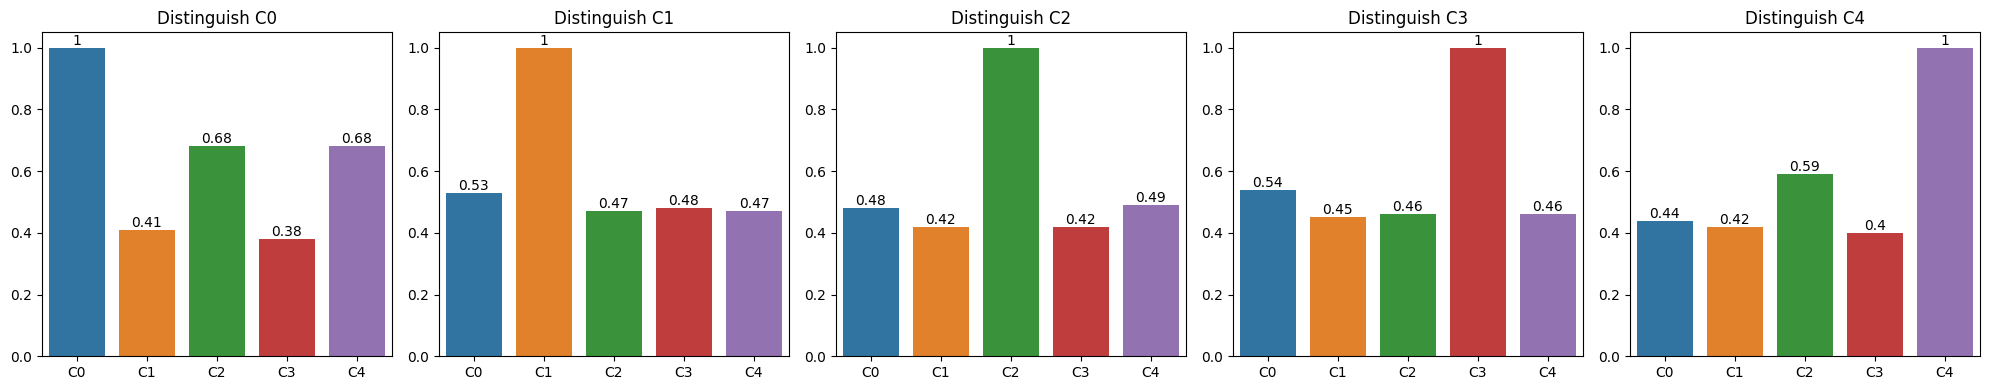

In [16]:
n_sample = 100
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
axes = axes.flatten()
idx = 0

for aligning_causal_variable in ["C0", "C1", "C2", "C3", "C4"]:
    input_output_dict = one_good_way_to_prepare_counterfactual_alignment_data(
        program[1],
        n_sample,
        aligning_causal_variable,
        all_vocab, synonyms_pairs, synonyms_dict
    )
    
    ind_scores = []
    for alternative_var in ["C0", "C1", "C2", "C3", "C4"]:
        distinguishability_check = [input_output_dict["alternative_answers"][i][aligning_causal_variable] == 
         input_output_dict["alternative_answers"][i][alternative_var] 
         for i in range(len(input_output_dict["alternative_answers"]))
        ]
        ind_scores += [Counter(distinguishability_check)[True]/n_sample]
    ax = axes[idx]
    ax = sns.barplot(x=["C0", "C1", "C2", "C3", "C4"], y=ind_scores, ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_title(f'Distinguish {aligning_causal_variable}')
    idx += 1

plt.tight_layout()
plt.show()

After we make our dataset generation better, we can now generate our alignment training data.

In [17]:
train_cdataset = make_supervised_counterfactual_data_module_single_preload(
    program,
    "op1",
    20000,
    target_word_beam, 
    [8, 9], # this is for fixed position interventions.
    tokenizer,
    Dataset.from_dict(dataset_to_check)
)
print(train_cdataset[0])

# verify sequence length, intervention postion index, etc..
for e in train_cdataset:
    assert len(e["input_ids"]) == len(e["source_input_ids"])
    assert len(e["input_ids"]) == 11
    assert e["token_range"][0] == 8
    assert e["token_range"][1] == 9
    assert e["source_token_range"][0] == 8
    assert e["source_token_range"][1] == 9

Running tokenizer on the test dataset:   0%|          | 0/20000 [00:00<?, ? examples/s]

{'intervention_ids': 0, 'input_ids': [30898, 11, 29271, 11, 40240, 11, 20216, 11, 49328, 28, 17821], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'source_input_ids': [3391, 11, 31385, 11, 3391, 11, 38150, 11, 3391, 28, 17821], 'source_attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 17821], 'token_range': [8, 9], 'source_token_range': [8, 9]}


#### Sanity check on our Boundless DAS code.

One sanity check we can run to check whether we can correctly perform intervention with our neural network is to **align the output node**, which is `op5` in our case with the last token embedding at the last layer before the LM head. If we visualize the aligning variable and the aligning neural representations in the transformer, we will have something like this,

neural model aligning representations:


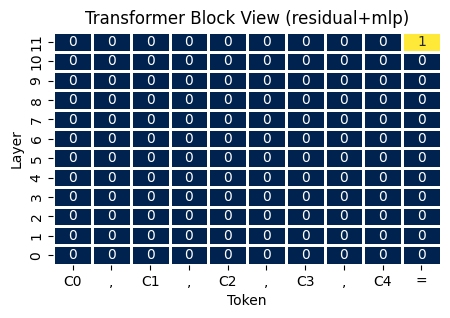

high-level model aligning variable:


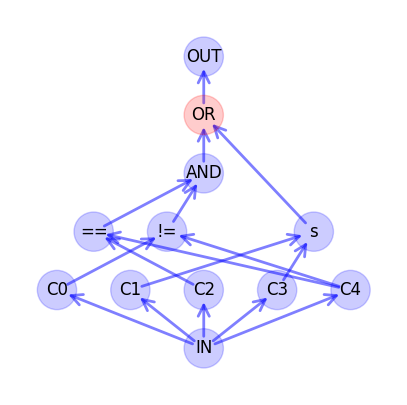

In [18]:
highlights = [(11, 9, 1.0)]
print("neural model aligning representations:")
xtick_labels = ["C0", ",", "C1", ",", "C2", ",", "C3", ",", "C4", "="]
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
print("high-level model aligning variable:")
visualize_program(program[1], intervene_on=9)

Here is the code to setup this alignment. And as you would've imagined, we actually don't need to do any training in this case if we are swapping the full token representation! Since, it will basically change the label of the `base example` to the label of the `source example`.

In [19]:
n_alignment_training_examples = 1000
counterfactual_data_module = make_supervised_counterfactual_data_module(
    program,
    "op5",
    n_alignment_training_examples,
    target_word_beam, 
    [9, 10],
    tokenizer
)
test_cdataset = counterfactual_data_module["test_dataset"]
print(test_cdataset[0])

batch_size = 128
left_tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    padding_side='left',
    use_fast=False
)
left_tokenizer.pad_token = left_tokenizer.eos_token

test_dataloader = DataLoader(
    test_cdataset,
    batch_size=128, 
    sampler=RandomSampler(test_cdataset),
    collate_fn=DataCollatorForAlignmentDataset(
        left_tokenizer,
        label_pad_token_id=IGNORE_INDEX,
        padding="longest"
    )
)

alignment_config = {
    'layer': 11, # last layer!
    'num_of_das_token' : 1
}
model = AutoAlignableModel.from_pretrained(
    model_name_or_path,
    alignment_config=alignment_config,
    torch_dtype=torch.bfloat16,
    cache_dir="../../../.cache_dir/"
)
model_type = AutoConfig.from_pretrained(
    model_name_or_path
).architectures[0]

# set off the gradients among all other layers.
for name, param in model.named_parameters():
    if "rotate_layer" not in name and "intervention_boundaries" not in name:
        param.requires_grad = False
    else:
        logger.info(f"Requiring gradients on layer: {name}")
_ = model.to(torch.device("cuda")) # no rank is needed!

# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -2], dim=-1)
        correct_labels = (actual_test_labels==pred_test_labels)
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count/total_count, 2)
    return {"accuracy" : accuracy}

aligner = Aligner(
    model,
    logger=logger,
    is_wandb=False,
    is_master=True,
    n_gpu=1,
    model_name=model_type,
    device="cuda",
    compute_metrics=compute_metrics
)

Running tokenizer on the train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Running tokenizer on the validation dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Running tokenizer on the test dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'intervention_ids': 0, 'input_ids': [27218, 11, 37485, 11, 41081, 11, 48870, 11, 27218, 28, 17821], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'source_input_ids': [41970, 11, 30905, 11, 20214, 11, 37321, 11, 20214, 28, 17821], 'source_attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 17821], 'token_range': [9, 10], 'source_token_range': [9, 10]}


<Axes: >

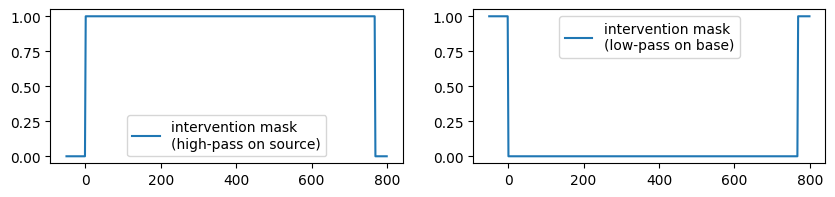

In [20]:
model.eval() # we set dropout to 0. when evaluating. DAS we allow dropout.
model.transformer.temperature.data = torch.tensor(0.01, device='cuda:0', dtype=torch.bfloat16)
temperature = model.transformer.temperature.data.tolist()
boundary = model.transformer.intervention_boundaries.data[0].tolist()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
sns.lineplot(
    ax=axs[0],
    x=torch.arange(-50, 800), 
    y=sigmoid_boundary_sigmoid(torch.arange(-50, 800), 0, 768*boundary, temperature),
    label='intervention mask\n(high-pass on source)'
)
sns.lineplot(
    ax=axs[1],
    x=torch.arange(-50, 800), 
    y=1-sigmoid_boundary_sigmoid(torch.arange(-50, 800), 0, 768*boundary, temperature),
    label='intervention mask\n(low-pass on base)'
)

In [21]:
with torch.no_grad():
    results = aligner.iia_eval(test_dataloader)
print(results)

{'accuracy': 0.99}


**Great!** Here you should be able to get a pretty good IIA, since it should be very close to the task performance on the GPT-2 model that we just finetuned on this task!

#### Connections to Causal Abstraction [Geiger et. al., 2020]

Now, what if we swap the whole token representations at previous layers? What are the IIAs? This is causal abstraction framework out-of-the-box without any training essentially. Let's have the causal abstraction baseline for all variables we are aligning. Later, we can also ground Boundless DAS results with causal abstraction in a concrete way as to see how Boundless DAS can help in aligning causal variables more effectively.

In [22]:
LOAD_FROM_CACHE = True
if not LOAD_FROM_CACHE:
    causal_abstraction_results = {}
    for variable_name in ["op1", "op2", "op3", "op4", "op5"]:
        causal_abstraction_results[variable_name] = []
        for pos in [6, 7, 8, 9]:
            n_alignment_training_examples = 1000
            counterfactual_data_module = make_supervised_counterfactual_data_module(
                program,
                variable_name,
                n_alignment_training_examples,
                target_word_beam, 
                [pos, pos+1],
                tokenizer
            )
            test_cdataset = counterfactual_data_module["test_dataset"]

            batch_size = 128
            left_tokenizer = AutoTokenizer.from_pretrained(
                "gpt2",
                padding_side='left',
                use_fast=False
            )
            left_tokenizer.pad_token = left_tokenizer.eos_token

            test_dataloader = DataLoader(
                test_cdataset,
                batch_size=128, 
                sampler=RandomSampler(test_cdataset),
                collate_fn=DataCollatorForAlignmentDataset(
                    left_tokenizer,
                    label_pad_token_id=IGNORE_INDEX,
                    padding="longest"
                )
            )
            # print(f"aligning var={variable_name} at position={pos} across layers...")
            for layer in range(12):
                alignment_config = {
                    'layer': layer, # last layer!
                    'num_of_das_token' : 1
                }
                model.transformer.alignment_config = alignment_config # a hack
                with torch.no_grad():
                    test_iia = aligner.iia_eval(test_dataloader)
                causal_abstraction_results[variable_name].append((layer, pos, test_iia["accuracy"]))
    json.dump(
        causal_abstraction_results, 
        open("./tutorial_results/causal_abstraction_results_noninput.json", "w"),
        indent=4
    )
else:
    causal_abstraction_results = json.load(open("./tutorial_results/causal_abstraction_results_noninput.json"))

In [ ]:
input_token_causal_abstraction_results = {}
for variable_name in ["C0", "C1", "C2", "C3", "C4"]:
    print(f"aligning var={variable_name} across all layers...")
    input_token_causal_abstraction_results[variable_name] = []
    preload_dataset = Dataset.from_dict(
        prepare_counterfactual_alignment_data_simple(
            program[1],
            100,
            variable_name,
            all_vocab, synonyms_pairs, synonyms_dict
        )
    )
    for pos in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        test_cdataset = make_supervised_counterfactual_data_module_single_preload(
            program,
            variable_name,
            0,
            target_word_beam, 
            [pos, pos+1],
            tokenizer,
            preload_dataset
        )

        batch_size = 128
        left_tokenizer = AutoTokenizer.from_pretrained(
            "gpt2",
            padding_side='left',
            use_fast=False
        )
        left_tokenizer.pad_token = left_tokenizer.eos_token

        test_dataloader = DataLoader(
            test_cdataset,
            batch_size=128, 
            sampler=RandomSampler(test_cdataset),
            collate_fn=DataCollatorForAlignmentDataset(
                left_tokenizer,
                label_pad_token_id=IGNORE_INDEX,
                padding="longest"
            )
        )
        
        for layer in range(12):
            alignment_config = {
                'layer': layer, # last layer!
                'num_of_das_token' : 1
            }
            model.transformer.alignment_config = alignment_config # a hack
            with torch.no_grad():
                test_iia = aligner.iia_eval(test_dataloader)
            input_token_causal_abstraction_results[variable_name].append((layer, pos, test_iia["accuracy"]))

C3 neural model aligning representations:


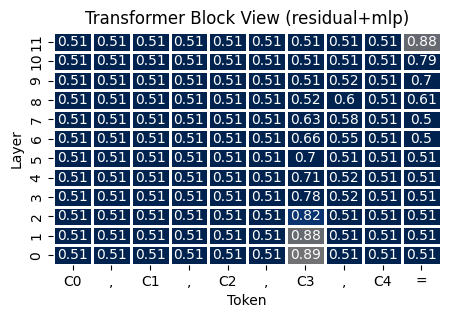

In [150]:
variable_name = "C3"
highlights = input_token_causal_abstraction_results[variable_name]
print(f"{variable_name} neural model aligning representations:")
xtick_labels = ["C0", ",", "C1", ",", "C2", ",", "C3", ",", "C4", "="]
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)

Let's save the results later when comparing to Boundless DAS.

#### Before we do alignment, let's go over basic statistics to understand our results better.

What does it mean to successfully find *any* alignment? We define a metrics called interchange intervention accuracy (IIA). IIA means how well does the counterfactual behaviors of the neural model align with the high level model under known interventions. 

There are obvious caveats if you think about how to ground IIA, although it is named as accuracy! Here are some starting points for you to think about. Note that how to interpret IIA still remains a challenging question.

- **What is a good baseline?** Is 50% a baseline for IIA? Probably not. Just like your classification accuracy, 50%, if as a random baseline, needs to assume there is no labeling bias. Let's say, the golden label is skewed, then the baseline IIA is probably not 50%. For instance, if you look at the dataset statistics above, more than **87%** of times, base labels are not altered with interventions!

- **No training at all, what is your IIA?** Let's give a shot with a random rotation, and some random intervention sizes, what is the IIA? For instance, if you randomly intervene on 1 neuron, probably your predicted counterfactual label will be your base label! And the golden counterfactual label maybe very similar to the base labels as well. So again, you need to think harder on how to interpret IIA. If you see a IIA score of 75%, it does not neccessary mean you find a good alignment. Always think dummy baselines.

- **Relative IIA rankings can make more sense.** While absolute IIA is harder to interpret given all the reasons above, relative IIA scores are easier to reason about.

Now we are ready to scale our experiments to search other causal variables in the neural network. To speed up your training with `bfloat16`, you can uncomment the following lines and it will overwrite two files to help you to speed up.

In [ ]:
#########################################
# DO NOT RUN UNLESS YOU READ LINES ABOVE
# !cp ../../torch3.8_overwrite/init.py /opt/conda/envs/wuzhengx-bootleg/lib/python3.9/site-packages/torch/nn/
# !cp ../../torch3.8_overwrite/parametrizations.py /opt/conda/envs/wuzhengx-bootleg/lib/python3.9/site-packages/torch/nn/utils/
#########################################

### Chapter 3: To search more high-level causal variables.

We have provided a script that will help you kick off these runs in different processes to speed up the alignment process. Since the model is small and the task is simple, for a single Boundless DAS search, it should take about 1-2 mins on a single 12G GPU.

We also assume you have `wandb` installed and enabled. We will port results from `wandb` after training to do analysis!

In [ ]:
#########################################
# The following commands will search target causal variable across layers and certain position.
# !CUDA_VISIBLE_DEVICES=0 bash run_experiments.sh 0 11 "op5" "9_10"
# !CUDA_VISIBLE_DEVICES=0 bash run_experiments.sh 0 11 "op5" "8_9"
# !CUDA_VISIBLE_DEVICES=0 bash run_experiments.sh 0 11 "op5" "7_8"
# !CUDA_VISIBLE_DEVICES=0 bash run_experiments.sh 0 11 "op5" "6_7"

# !CUDA_VISIBLE_DEVICES=1 bash run_experiments.sh 0 11 "op4" "9_10"
# !CUDA_VISIBLE_DEVICES=1 bash run_experiments.sh 0 11 "op4" "8_9"
# !CUDA_VISIBLE_DEVICES=1 bash run_experiments.sh 0 11 "op4" "7_8"
# !CUDA_VISIBLE_DEVICES=1 bash run_experiments.sh 0 11 "op4" "6_7"

# !CUDA_VISIBLE_DEVICES=2 bash run_experiments.sh 0 11 "op1" "9_10"
# !CUDA_VISIBLE_DEVICES=2 bash run_experiments.sh 0 11 "op1" "8_9"
# !CUDA_VISIBLE_DEVICES=2 bash run_experiments.sh 0 11 "op1" "7_8"
# !CUDA_VISIBLE_DEVICES=2 bash run_experiments.sh 0 11 "op1" "6_7"

# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op2" "9_10"
# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op2" "8_9"
# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op2" "7_8"
# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op2" "6_7"

# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op3" "9_10"
# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op3" "8_9"
# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op3" "7_8"
# !CUDA_VISIBLE_DEVICES=3 bash run_experiments.sh 0 11 "op3" "6_7"
#########################################

### Chapter 4: Analysis of variable alignments

Once you obtain interesting alignment results, you can start analyze them. Before we start, let's review our metrics here!

**Interchange Intervention Accuracy (IIA)**: this is a single metrics we are using to evaluate our alignments. It means how well does the interchange intervention align with the counterfactual behaviors of our aligning causal model. This metrics, we think, is bounded by the task performance on average. As a result, the best counterfactual accuracy is the task performance. 

**Intervention Boundaries**: this is a learned artifact of Boundless DAS, it means how many neurons are needed for the alignment **in the non-standard basis**. We will not focus on this one for now. This one has connection to information compression, bottleneck network, etc..

In [76]:
# readin results: test set IIA for different locations, variables, etc..
import wandb
api = wandb.Api()
entity = input("enter your wandb entity (typically your username): ")
project = input("enter your wandb project: ") 
runs = api.runs(entity + "/" + project)

def parse_wandb_runname(name):
    variable_name = name.split("alignment_variable.")[-1].split(".")[0]
    layer = int(name.split("intl.")[-1].split(".")[0])
    pos = int(name.split("token_position_strategy.")[-1].split(".")[0].split("_")[0])
    return variable_name, layer, pos

alignment_results = {}
for run in tqdm(runs): 
    test_iia = run.summary["test/accuracy"]
    
    variable_name, layer, pos = parse_wandb_runname(run.name)
    
    if variable_name not in alignment_results:
        alignment_results[variable_name] = []
    alignment_results[variable_name].append((layer, pos, test_iia))

enter your wandb entity (typically your username): wuzhengx_amazon
enter your wandb project: Boundless-DAS-word-logic


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552/552 [00:01<00:00, 315.63it/s]


**Read before you see the results**: **0** in the heatmaps below simply means we did not run alignment on those positions. It does not mean 0% IIA.

How does `op1` align with each token representation?

In [ ]:
variable_name = "op1"
xtick_labels = ["C0", ",", "C1", ",", "C2", ",", "C3", ",", "C4", "="]
highlights = causal_abstraction_results[variable_name]
print(f"Causal Abstraction {variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
highlights = alignment_results[variable_name]
print(f"Boundless DAS {variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
print(f"{variable_name} high-level model aligning variable:")
visualize_program(program[1], intervene_on=int(variable_name[-1])+4)

How does `op2` align with each token representation?

In [ ]:
variable_name = "op2"
highlights = causal_abstraction_results[variable_name]
print(f"Causal Abstraction {variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
highlights = alignment_results[variable_name]
print(f"{variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
print(f"{variable_name} high-level model aligning variable:")
visualize_program(program[1], intervene_on=int(variable_name[-1])+4)

How does `op3` align with each token representation?

In [ ]:
variable_name = "C1"
highlights = causal_abstraction_results[variable_name]
print(f"Causal Abstraction {variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
highlights = alignment_results[variable_name]
print(f"{variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
print(f"{variable_name} high-level model aligning variable:")
visualize_program(program[1], intervene_on=int(variable_name[-1])+4)

How does `op4` align with each token representation?

In [ ]:
variable_name = "op4"
highlights = causal_abstraction_results[variable_name]
print(f"Causal Abstraction {variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
highlights = alignment_results[variable_name]
print(f"{variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
print(f"{variable_name} high-level model aligning variable:")
visualize_program(program[1], intervene_on=int(variable_name[-1])+4)

How does `op5` (the output label) align with each token representation?

In [ ]:
variable_name = "op5"
highlights = causal_abstraction_results[variable_name]
print(f"Causal Abstraction {variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
highlights = alignment_results[variable_name]
print(f"{variable_name} neural model aligning representations:")
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)
print(f"{variable_name} high-level model aligning variable:")
visualize_program(program[1], intervene_on=int(variable_name[-1])+4)

#### Some comments on these results

If you look at the alignment results, Boundless DAS is almost like always performing better than the vanilla causal abstraction with we swap the whole token representation. This means Boundless DAS, with its optimization process, it can disentangle linearly separable information much better comparing to activation patching / interchange intervention / activation scrubbing / etc.. So, if other methods do not work in your case or they do not provide salient results, try Boundless DAS and see if you can find representation for your causal variable quicker.

### Chapter 5: Causal circuits


global neural model aligning representations:


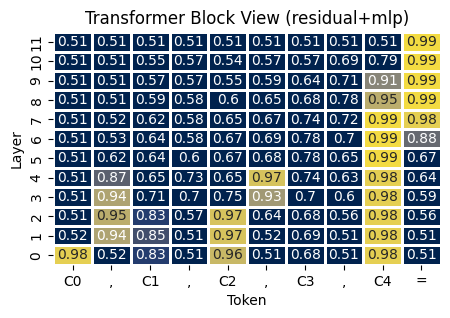

In [116]:
alignment_results_aggr = {}
for variable_name in alignment_results.keys():
    for ele in alignment_results[variable_name]:
        if (ele[0], ele[1]) not in alignment_results_aggr:
            alignment_results_aggr[(ele[0], ele[1])] = ele[2]
        else:
            alignment_results_aggr[(ele[0], ele[1])] = max(ele[2], alignment_results_aggr[(ele[0], ele[1])])
highlights = []
for k, v in alignment_results_aggr.items():
    highlights += [(k[0], k[1], v)]
print(f"global neural model aligning representations:")
xtick_labels = ["C0", ",", "C1", ",", "C2", ",", "C3", ",", "C4", "="]
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)

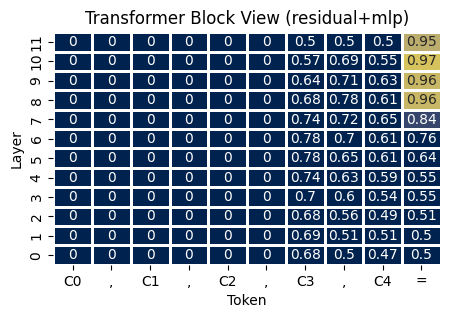

In [143]:
highlights = alignment_results["op3"]
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)

In [132]:
# TODO: finish here.
# Note: I will leave this part for another tutorial.
circuit_options = {
    'Option 1': [],
    # Add more options as needed...
}

@interact(circuit=circuit_options)
def interactive_plot_attention_graph(circuit):
    # Clear the current output
    plt.clf()

    # Redraw the plot with the selected edges
    plot_attention_graph(max_length=10, num_layers=12, highlight_edges=circuit)
    plt.show()

interactive(children=(Dropdown(description='circuit', options={'Option 1': [], 'Option 2': [((1, 2), (2, 2)), …

### Chapter 6: Some Mechanistic Interpretability with Causal Variables

How well does our alignments connect with *mechanistic interpretability*? Can we visualize the high-level concept at those location? Can we visualize or interpret how neural network actually do the equality check? In this section, we tried to discuss a bit along these questions.

**Very important**: Note that these analyses are post-hoc analyses of what Boundless DAS has found. It does not drive us to determine where to do DAS. In fact, these analyses do not involve (but can, if we study the rotated space) rotation matrix, and can be done separately by scanning through small neural networks such as GPT-2.

In [276]:
# let's just have our finetuned model without even the rotation wrapper.
model = GPT2LMHeadModel.from_pretrained(
    model_name_or_path,
    cache_dir="./.cache_dir/"
)
_ = model.to(torch.device("cuda")) # no rank is needed!

In [ ]:
variable_name = "op1"
highlights = alignment_results[variable_name]
print(f"{variable_name} neural model aligning representations:")
xtick_labels = ["C0", ",", "C1", ",", "C2", ",", "C3", ",", "C4", "="]
plot_transformer(max_length=10, num_layers=12, highlights=highlights, xtick_labels=xtick_labels)

Let's focus on `op1` here. We can sort of see that `op1` value is being computed on top of the token column of `C4` at the residual + mlp output stream. It seems like the computation involved at this node may invoke some equality check mechanism (well, hopefully). So, let's dive into this node, and analyze a bit more about its representations, weights, etc.. 

#### self-attention weights

In [ ]:
layer_4_attentions = []
# Please batch it, I am lazy here.
for _ in range(1000):
    random_inputs = tokenizer(",".join(random.sample(all_vocab, 5)), return_tensors="pt")
    random_inputs = {
        k: v.to(model.device) if isinstance(v, torch.Tensor) else v 
        for k, v in random_inputs.items()
    }
    random_output = model(
        input_ids=random_inputs['input_ids'],
        attention_mask=random_inputs['attention_mask'],
        output_attentions=True,
        output_hidden_states=True,
        return_dict=True
    )
    layer_4_attentions += [random_output.attentions[4][0].cpu().detach()]
averaged_layer_4_attention = torch.stack(layer_4_attentions, dim=0).mean(dim=0)

In [ ]:
plot_head_level_attention_heatmaps(
    averaged_layer_4_attention.numpy(),
    highlight_heads=[4, 12] # this is post-hoc stuff...
)

Aggregated attention scores across 1000 random draw examples actually show clear patterns over Head 4, Head 12 and some other heads. These heads look alike inductive heads

In [147]:
interested_layer_num = 8
layer_attentions = []
# Please batch it, I am lazy here.
for _ in range(1000):
    synonyms_pair = random.choice(synonyms_pairs)
    sampled_tokens = random.sample(all_vocab, 3)
    # incentivize it to have signals around synonyms
    sampled_tokens = [sampled_tokens[0], synonyms_pair[0], sampled_tokens[1], synonyms_pair[1], sampled_tokens[2]]
    random_inputs = tokenizer(",".join(sampled_tokens), return_tensors="pt")
    random_inputs = {
        k: v.to(model.device) if isinstance(v, torch.Tensor) else v 
        for k, v in random_inputs.items()
    }
    random_output = model(
        input_ids=random_inputs['input_ids'],
        attention_mask=random_inputs['attention_mask'],
        output_attentions=True,
        output_hidden_states=True,
        return_dict=True
    )
    layer_attentions += [random_output.attentions[interested_layer_num][0].cpu().detach()]
averaged_layer_attention = torch.stack(layer_attentions, dim=0).mean(dim=0)

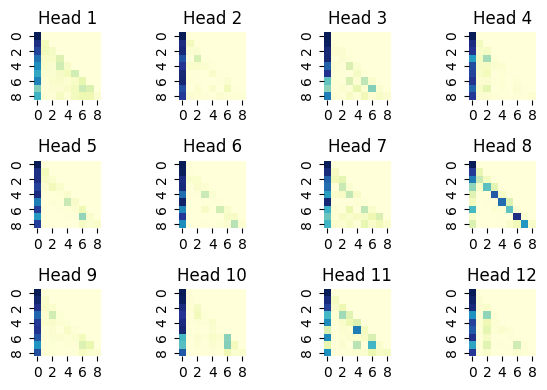

In [148]:
plot_head_level_attention_heatmaps(
    averaged_layer_attention.numpy(),
    highlight_heads=[] # this is post-hoc stuff...
)